# Chapter 02: Our first model, Grand Old Logistic Regression

The following is a Python implementation of [M02-glm.Rmd](M02-glm.Rmd).  I have tried to minimize the change to the narrative content.  This is an incomplete duplication.  

## Load input data heart.csv and ecoli.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

path = "heart.csv"
ecolipath = "ecoli.csv"
heart = pd.read_csv(path)
ecoli = pd.read_csv(ecolipath)

## Review the data, quick and easy EDA

View a few records (head/tail), dimension, number of rows and records and the variable names.
Everything is an object and mostly a list. We can index into a list to access the elements in the list. Python index runs from 0 to the length.

In [2]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
heart.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


### What is the shape of this dataset

How many  observations does it have (each row is an observation)
How many variables are available to us -- number of columns

In [4]:
heart.shape

(303, 14)

*shape* prints the row X column -- equivalent to *dim in R*

In [5]:
heart.shape[0]

303

In [6]:
heart.shape[1]

14

### Manipulating column names

Recall **heart = pd.read_csv(path)** so python would load the data into a pandas.core.frame.DataFrame with column names.  Here are some ways to manipulate header

In [7]:
heart.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [8]:
heart.columns[2]

'cp'

In [9]:
len(heart.columns)

14

let us change the name of the first column **NOTE: When R reads in the data the first variable is "ï..age".  Pandas does not exhibit that behavior.  This is how one would rename the variable IF it happened.**

In [10]:
heart = heart.rename(columns={"ï..age": "age"})

## Are the covariates correlated?

Numerically review the pairwise correlation amongst independent variables

In [11]:
heart.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


## Are there any constant feature vectors?
Let us find out if there are any constant variables.
Constant variables cannot possibly contribute to predicting the target.
For example, given this simple birds dataset, and that I saw a bird with two legs,
can you identify which bird that might be?

In [12]:
birds = pd.DataFrame(data={"legs": [2, 2, 2, 2, 2, 2, 2, 2], "name": ["crow", "pigeon", "owl", "eagle", "sparrow", "duck", "woodpecker", "humming bird"]})
birds

,legs,name
0,2,crow
1,2,pigeon
2,2,owl
3,2,eagle
4,2,sparrow
5,2,duck
6,2,woodpecker
7,2,humming bird


Let us write a utility function we can call on any list… we can also do length(unique(x)) < 1

In [13]:
def is_constant(x):
    t = x.value_counts() == x.shape[0]
    return t.any()
    
heart.apply(is_constant, axis=0)

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool

Let us plot,correlations using python analog to the pairs function

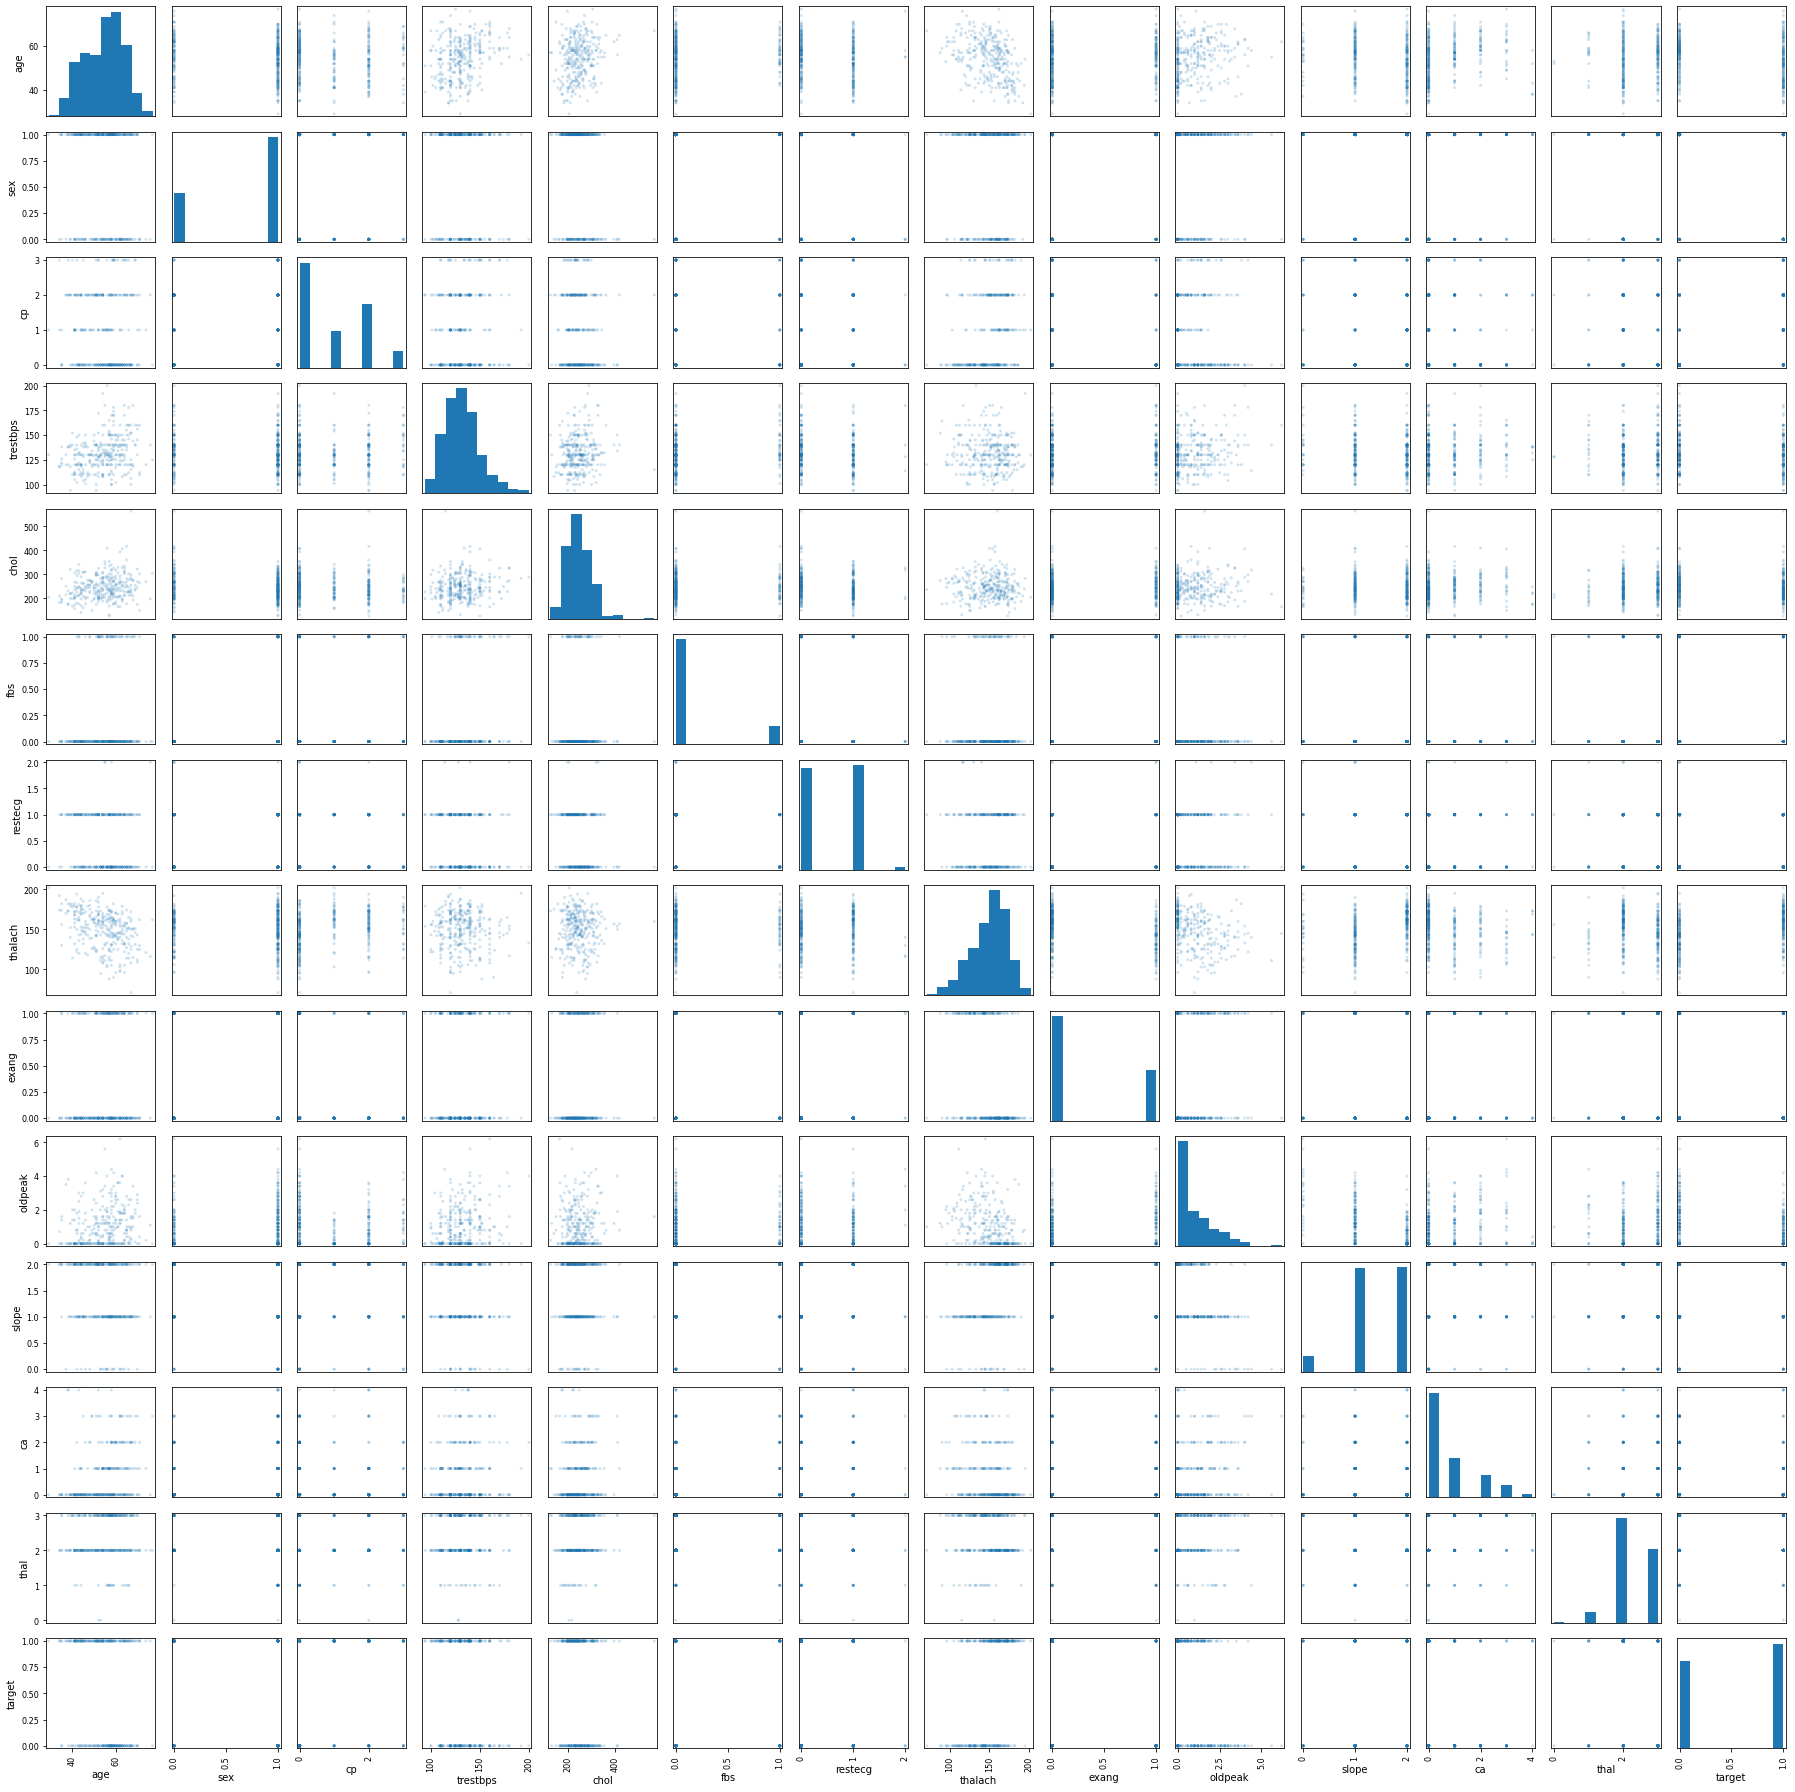

In [14]:
plt.rcParams['figure.figsize'] = [25, 25]
axes = pd.plotting.scatter_matrix(heart, alpha=0.2)
plt.tight_layout()

## What is our class/label variable?

Is the problem at hand *binary classification* or *multi-class classification!*?
Let us assume, our customers want us to predict **target** given the rest.

In [15]:
heart["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

## Class Imbalance
Let us try to understand the *distribution of the target variable.* Let us make sure
the distribution is balanced. 

### When is a class imbalanced?

If we find 1(minority) in 10 in the extreme case
or anything less than 1 (minority) in 6, we will consider our dataset to be imbalanced.
These are not hard rules but my intuition is as follows
if we are going to create training data with 70/30 split then a random 
sample that contains none or very few of the minority class becomes likely.
Our efforts to train a model is not going to be very fruitful. The model
may not know how to detect minority class or overwhelmed by majority class signature.

In [16]:
len(heart["target"].unique())

2

In [17]:
if len(heart["target"].unique()) == 2: 
    print("binary classification")
else:
    print("multi-class classification")

binary classification


CONSIDER WRITING SMALL ONE LINERS isBinaryClassification(classVector)
and one for, class imbalanced, isImbalancedData(classVector)
IMHO, only one[or two] instance of a certain class -- better to remove that class initially.

## First Classification run

Let us run a simple generalized linear model and try to
understand each variable and how important they are in 
determining the target variable.

we will **NOT** split the data as this is a trial run
and this run is to develop a rough draft script for
any classification exercise.

In [18]:
# You need to add this constant to get an intercept term in the summary
heart["intercept"] = 1
# Let's rearrange the columns to get the intercept to the top of the list
cols = list(heart.columns)
cols.remove("intercept")
cols.insert(0, "intercept")
heart = heart[cols]

Y = heart["target"]
X = heart.loc[:, heart.columns != "target"]

glm_model = sm.Logit(Y,X).fit()
print(glm_model.summary2())

Optimization terminated successfully.
         Current function value: 0.348904
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.494     
Dependent Variable: target           AIC:              239.4360  
Date:               2020-09-19 23:25 BIC:              291.4282  
No. Observations:   303              Log-Likelihood:   -105.72   
Df Model:           13               LL-Null:          -208.82   
Df Residuals:       289              LLR p-value:      7.2623e-37
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept      3.4505    2.5715   1.3418  0.1797  -1.5895   8.4905
age           -0.0049    0.0232  -0.2118  0.8323  -0.0503   0.

We will reject any variable with a p-value greater than 0.05.

## p-value
There is much debate regarding p-value. Nothing prevents us from saying
we will reject if p-value is greater than 0.07 after we run the model. 

While I respect that viewpoint, I continue to use
p-value as I use 0.05 always. Sometimes, I do experiment with variables
that are indicated as not-significant (p-value > 0.05 for that variable).
For the overall model significance I consistently use 0.05. I do not change that
to accept unreliable model.
I interpret p-value to be the probability of rejecting H0 (the hypothesis) when it is
actually, valid/true.

The p value is the probability of observing a sample value as extreme as, or more extreme than, the value actually observed, given that the null hypothesis is true.
p value represents the risk of rejecting a true null hypothesis. It is the probability of a Type I error if the null hypothesis is rejected.

## Type I and Type II error
When a Type I error (a) is committed, a true null hypothesis is rejected; the innocent person is unjustly convicted. The value is called the level of significance and is the probability of rejecting the true null. With
a Type II error (b), one fails to reject a false null hypothesis; the result is an unjust acquittal, with the guilty person going free. In our system of justice, it is more important to reduce the probability of convicting
the innocent than that of acquitting the guilty. Similarly, hypothesis testing places a greater emphasis
on Type I errors than on Type II errors.

## Ethical Practice
Statistical tools cannot enforce ethical science or human behavior.
So when running  a ML experiment, write ahead of time what your 
acceptance criteria is prior to running the experiment. Include the result
in your reporting regardless of the results.

## File Drawer Problem
Include all results from all the experiments, regardless of the results whether it is in agreement with your expectation or NOT. Eliminate the so called File Drawer problem -- of not including unfavorable results --.

In [19]:
glm_model.pvalues < 0.05

intercept    False
age          False
sex           True
cp            True
trestbps     False
chol         False
fbs          False
restecg      False
thalach       True
exang         True
oldpeak       True
slope        False
ca            True
thal          True
dtype: bool

In [20]:
sig_cols = list(X.columns[glm_model.pvalues < 0.05])
sig_cols

['sex', 'cp', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']

### p-values

Now let us rerun the model with the significant variables, that is, with p-value <0.05

In [21]:
cols = list(X.columns[glm_model.pvalues < 0.05])
cols.insert(0, "intercept")
X2 = heart[cols]

model_2 = sm.Logit(Y,X2).fit()
print(model_2.summary2())

Optimization terminated successfully.
         Current function value: 0.368502
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.465     
Dependent Variable: target           AIC:              239.3125  
Date:               2020-09-19 23:25 BIC:              269.0223  
No. Observations:   303              Log-Likelihood:   -111.66   
Df Model:           7                LL-Null:          -208.82   
Df Residuals:       295              LLR p-value:      1.8244e-38
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept      0.4636    1.4816   0.3129  0.7544  -2.4404   3.3675
sex           -1.3896    0.4058  -3.4245  0.0006  -2.1849  -0.

So we removed predictors based on p-value and our deviance of the revised model is higher by about 6%. So let us compute the VIF factors for the model predictors and determine if we removed some variables that should not have been removed.

<span style="color:red">**NOTE: I have not been successful in replicating the VIF analysis in python at this time.  I will be proceeding as if I had the variables identified.**</span>

Now let us predict using our model. The model has already seen the data. We do not expect our model, to reproduce at 100%. But we do expect that our model performs better than random guess. If our model under-performs random guess, then that would be an indication of the model’s inability to learn at all. Here in such cases that model is deficient and is a case of under-fitting.

In [22]:
X3 = heart[["intercept", "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"]]

newmodel = sm.Logit(Y,X3).fit()
print(newmodel.summary2())

Optimization terminated successfully.
         Current function value: 0.348904
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.494     
Dependent Variable: target           AIC:              239.4360  
Date:               2020-09-19 23:25 BIC:              291.4282  
No. Observations:   303              Log-Likelihood:   -105.72   
Df Model:           13               LL-Null:          -208.82   
Df Residuals:       289              LLR p-value:      7.2623e-37
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept      3.4505    2.5715   1.3418  0.1797  -1.5895   8.4905
age           -0.0049    0.0232  -0.2118  0.8323  -0.0503   0.

Now let us compute the performance of the classifier.As indicated above, a random choice would have scored 0.5. If our model is any good it must perform better than 0.5.

In [23]:
newmodel.pvalues < 0.05

intercept    False
age          False
sex           True
cp            True
trestbps     False
chol         False
fbs          False
restecg      False
thalach       True
exang         True
oldpeak       True
slope        False
ca            True
thal          True
dtype: bool

In [24]:
predYprob = newmodel.predict(X)
predY = [ 0 if x < 0.5 else 1 for x in predYprob]
Counter(predY)

Counter({1: 184, 0: 119})

In [25]:
Counter(Y)

Counter({1: 165, 0: 138})

In [26]:
pd.DataFrame(confusion_matrix(Y, predY))

,0,1
0,106,32
1,13,152


In [27]:
print(classification_report(Y, predY, digits = 4))

              precision    recall  f1-score   support

           0     0.8908    0.7681    0.8249       138
           1     0.8261    0.9212    0.8711       165

    accuracy                         0.8515       303
   macro avg     0.8584    0.8447    0.8480       303
weighted avg     0.8555    0.8515    0.8500       303



Accuracy is 84.49%.
But this is from data the model has already seen.

## Underfitting 
A Model with an accuracy of 70% or higher is performant, and therefore, is not underfitting. We can surmise the model is capable of learning. It is better than
random guess which would yield 50% accuracy.

Business is not interested in predicting what has already happened. Business need help
when there is uncertainty and not enough information is available. How will this model perform when a new patient or a new customer arrives. 
*How can we estimate model performance over never seen before data? That is the capability,
**generalize**, we are seeking. Is Life not the response to un-controlled, un-anticipated, unpredictable events?*

## Never seen before data -- HOLD-OUT
We need to devise a process to find out how our model performs when new data is
presented. To do that, we will split our dataset into two disjoint partitions: a training set **70%** and a test set **30%**.
We will hold out some of the data given to us as test set.
We will train the model on the training set. 
Measure its performance on the training set.
Make sure it is at or near 0.85 accuracy, affirming it still is capable of learning with **70%** of the data.
Then we predict the lable for the observations in the test set. 
Measure the performance on the test set.

## Over-fitting, learning from noise
We normally expect performance over test set to be less than training set. If the performance over test set decreases by 20% or more, our model is over-fitting. Two well known causes of over-fitting, (1) *model complexity* and (2) *over-training*. The model has captured both noise and signal and the noise is reflected in the predictions, resulting in sub-optimal **generalization**.

*I have quoted many numerical values as above, but they are my discipline definitely not a rule. They are my choice. You can set your own limits, please do so before running the model and do not change.*

## Data Partition Repeatability/Reproducibility
Let us split our data into "random" test/train disjoint partitions. Always set the seed.
We will train our model on the training set. We will predict using training set to
ensure the model is NOT under-fitting and then predict using the test set, some data
model is not trained on. The test set represents new data. We will evaluate the model's ability to generalize.
We can determine if our model is *over-fitting* influenced by noise in the training set.

<span style="color:red">**NOTE: The RMD file used set.seed and a selection process to choose the training/test split.  I will show how could be done in python but will ultimately use a list of the same observations so the model results are consistent.**</span>

In [28]:
# Here's how to split the data in python
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 43)

# Here's the rows selected by the process in R
r_tstidx = [44, 296, 196, 149, 66, 261, 216, 7, 167, 130, 270, 225, 180, 147, 173, 22, 78, 228, 259, 110, 161, 142, 297, 72, 301, 39, 249, 274, 81, 121, 286, 98, 55, 230, 263, 120, 102, 291, 49, 245, 128, 166, 40, 154, 89, 218, 43, 165, 85, 184, 158, 303, 150, 169, 170, 67, 99, 9, 21, 205, 123, 209, 300, 234, 281, 5, 69, 268, 74, 93, 236, 30, 254, 279, 45, 176, 90, 233, 237, 103, 38, 191, 220, 194, 285, 217, 80, 115, 88, 299]
tstidx = heart.index.isin([x - 1 for x in r_tstidx])
trdata = heart[~tstidx]
tsdata = heart[tstidx]

cols = sig_cols.copy()
cols.insert(0, "intercept")
X_train = trdata[cols]
Y_train = trdata["target"]
X_test = tsdata[cols]
Y_test = tsdata["target"]

glm_trmodel = sm.Logit(Y_train, X_train).fit()
print(glm_trmodel.summary2())

Optimization terminated successfully.
         Current function value: 0.360032
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.475     
Dependent Variable: target           AIC:              169.3736  
Date:               2020-09-19 23:25 BIC:              196.2639  
No. Observations:   213              Log-Likelihood:   -76.687   
Df Model:           7                LL-Null:          -146.17   
Df Residuals:       205              LLR p-value:      8.3695e-27
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept      1.3254    1.8204   0.7281  0.4666  -2.2426   4.8934
sex           -1.8679    0.5377  -3.4738  0.0005  -2.9218  -0.

In [29]:
predYprob = glm_trmodel.predict(X_train)
predYprob[:6]

0    0.871827
1    0.518413
2    0.934305
3    0.803125
5    0.759952
7    0.775089
dtype: float64

In [30]:
Counter(Y_train)

Counter({1: 119, 0: 94})

In [31]:
predY = [ 0 if x < 0.5 else 1 for x in predYprob]
Counter(predY)

Counter({1: 129, 0: 84})

In [32]:
pd.DataFrame(confusion_matrix(Y_train, predY))

,0,1
0,72,22
1,12,107


In [33]:
print(classification_report(Y_train, predY, digits = 4))

              precision    recall  f1-score   support

           0     0.8571    0.7660    0.8090        94
           1     0.8295    0.8992    0.8629       119

    accuracy                         0.8404       213
   macro avg     0.8433    0.8326    0.8359       213
weighted avg     0.8417    0.8404    0.8391       213



Accuracy on training data is 0.8404 not bad..model is capable of learning.
Now let us predict the class for never seen before data.
That is our 'held out' test dataset. This is what matters to the business.

In [34]:
predts = glm_trmodel.predict(X_test)
predtsclass = [ 0 if x < 0.5 else 1 for x in predts]
Counter(predtsclass)

Counter({1: 47, 0: 43})

In [35]:
Counter(Y_test)

Counter({1: 46, 0: 44})

In [36]:
pd.DataFrame(confusion_matrix(Y_test, predtsclass))

,0,1
0,35,9
1,8,38


In [37]:
print(classification_report(Y_test, predtsclass, digits = 4))

              precision    recall  f1-score   support

           0     0.8140    0.7955    0.8046        44
           1     0.8085    0.8261    0.8172        46

    accuracy                         0.8111        90
   macro avg     0.8112    0.8108    0.8109        90
weighted avg     0.8112    0.8111    0.8110        90



Accuracy on the test set (held out data or never seen before data) 
is 0.8111, and has fallen down from accuracy obtained during training phase 0.84. The drop  is about 4% drop in performance and therefore we conclude Model is not over-fitting.
WHAT IF, our performance had fallen quite a bit, say more than 25%, from training to testing phase. That would be a classic case of overfitting. That limit 25% is my discipline. It is not a rule. In consultation with your sponsor you set, these limits and follow it with discipline.

* There are many advanced techniques to mitigate overfitting: 
    +   LASSO, 
    +   RIDGE, and 
    +   Cross Validation. 
  
Here, We will remove some variables and see if it has any bearing on our results.

In [38]:
cols = ["intercept", "cp", "ca" ,"thal", "oldpeak"]
X_train = trdata[cols]
X_test = tsdata[cols]
tst_model2 = sm.Logit(Y_train, X_train).fit()
print(tst_model2.summary2())

Optimization terminated successfully.
         Current function value: 0.420774
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.387     
Dependent Variable: target           AIC:              189.2498  
Date:               2020-09-19 23:25 BIC:              206.0563  
No. Observations:   213              Log-Likelihood:   -89.625   
Df Model:           4                LL-Null:          -146.17   
Df Residuals:       208              LLR p-value:      1.5954e-23
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept      2.9665    0.7912   3.7492  0.0002   1.4157   4.5172
cp             0.9528    0.1922   4.9586  0.0000   0.5762   1.

In [39]:
tr_tst_pred = tst_model2.predict(X_test)
tr_pred_class = [ 0 if x < 0.5 else 1 for x in tr_tst_pred]
pd.DataFrame(confusion_matrix(Y_test, tr_pred_class))

,0,1
0,35,9
1,9,37


In [40]:
print(classification_report(Y_test, tr_pred_class, digits = 4))

              precision    recall  f1-score   support

           0     0.7955    0.7955    0.7955        44
           1     0.8043    0.8043    0.8043        46

    accuracy                         0.8000        90
   macro avg     0.7999    0.7999    0.7999        90
weighted avg     0.8000    0.8000    0.8000        90



Accuracy is 0.8. Accuracy on training data was 0.8169014. There is no over-fitting. So we move on. Now let us visualize our performance using ROC plots.

<span style="color:red">**Due to time constraints I will not be duplicating/translating all the code into python**</span>

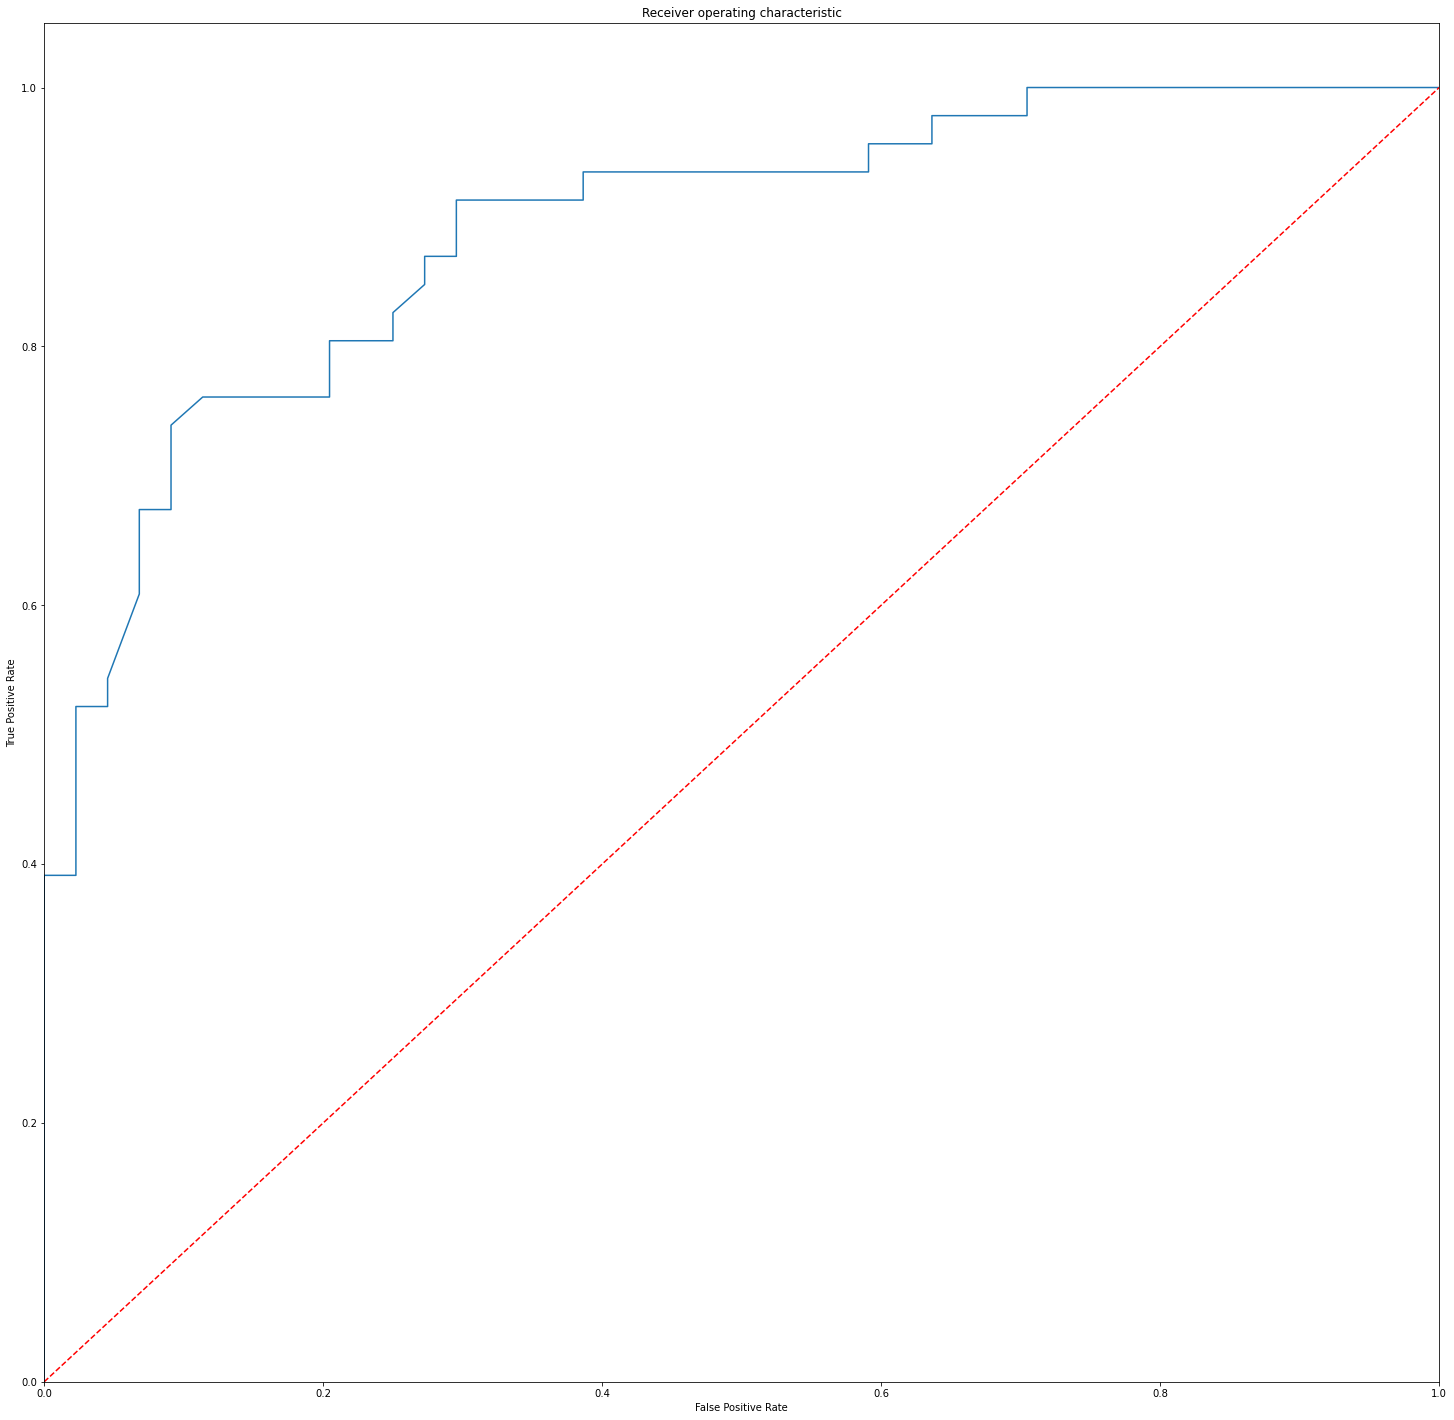

In [41]:
fpr, tpr, thresholds = roc_curve(Y_test, tr_tst_pred)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [42]:
print("AUC = " + str(roc_auc_score(Y_test, tr_tst_pred)))

AUC = 0.8905632411067192


We would prefer 90 or above...but AUC=0.89 and accuracy = 0.8 is acceptable.
the recall for this learner is 0.8718 and precision is 0.7727 and their geometric mean, aka F-Score is 0.8193.

## Logistic Regression is a goto algo!!
Definitely, GLM is doing better than a random guess!!! 
Logistic Regression is an excellent baseline algorithm,
My opinion, one must always must perform logistic regression in any ML exercise as a base line.
To show some respect, to grand old **Ockham and his razor**, do NOT use, ANY exotic hyper-parameters, at this stage,
Use just plain vanilla models, as much as possible using objective criteria.
Try to refine programmatically and numerically without requiring human intervention.
That is smart!

*Most importantly there is significant mathematics, statistics and probability behind these algorithms. In the word document, we take a deeper look.*
This module will serve as a template, for all our clinical modules in this course we will provide. 

* We will include
   +   R script, 
   +   RMD Script, 
   +   HTML (from the RMD) and 
   +   an essay in word format.
  
Next Module we will take up Naive Bayes, another parametric model.